In [4]:
from pathlib import Path
import warnings
import os

from distribution_inference.datasets.utils import get_dataset_wrapper, get_dataset_information
from distribution_inference.attacks.utils import get_dfs_for_victim_and_adv
from distribution_inference.attacks.whitebox.utils import get_attack, wrap_into_loader
from distribution_inference.attacks.whitebox.affinity.utils import get_loader_for_seed_data
from distribution_inference.config import DatasetConfig, AttackConfig, WhiteBoxAttackConfig, TrainConfig
from distribution_inference.utils import flash_utils, warning_string
from distribution_inference.logging.core import AttackResult
load_config = Path("./cel_AMC_interp.json")
meta_path = "/p/adversarialml/as9rw/tmp/celeba/Male"

In [5]:
attack_config: AttackConfig = AttackConfig.load(
        load_config, drop_extra_fields=False)
wb_attack_config: WhiteBoxAttackConfig = attack_config.white_box
train_config: TrainConfig = attack_config.train_config
data_config: DatasetConfig = train_config.data_config
if train_config.misc_config is not None:
        # TODO: Figure out best place to have this logic in the module
    if train_config.misc_config.adv_config:
            # Scale epsilon by 255 if requested
        if train_config.misc_config.adv_config.scale_by_255:
            train_config.misc_config.adv_config.epsilon /= 255
if len(attack_config.values) != 1:
        warnings.warn(warning_string(
            "\nTesting one meta-classifier against multiple ratios.\n"))
values_to_test = [str(x) for x in attack_config.values]
folders = os.listdir(meta_path)
for value in values_to_test:
    if value not in folders:
        raise ValueError(
            f"No model found for value {value} in {meta_path}")
#flash_utils(attack_config)
ds_wrapper_class = get_dataset_wrapper(data_config.name)

    # Get dataset info object
ds_info = get_dataset_information(data_config.name)()

    # Create new DS object for both and victim
_, data_config_vic_1 = get_dfs_for_victim_and_adv(
        data_config)
ds_vic_1 = ds_wrapper_class(data_config_vic_1, skip_data=True)

In [6]:
models_vic_1 = ds_vic_1.get_models(
            train_config,
            n_models=attack_config.num_victim_models,
            on_cpu=attack_config.on_cpu,
            shuffle=False,
            model_arch=attack_config.victim_model_arch,
            custom_models_path=None,)

        # For each value (of property) asked to experiment with
for i, prop_value in enumerate([attack_config.values[0]]):
            # Creata a copy of the data config, with the property value
            # changed to the current value
    _, data_config_vic_2 = get_dfs_for_victim_and_adv(
                data_config, prop_value=prop_value)

            # Create new DS object for both and victim (for other ratio)
    ds_vic_2 = ds_wrapper_class(data_config_vic_2, skip_data=True)

            # Load victim's model for other value
    models_vic_2 = ds_vic_2.get_models(
                train_config,
                n_models=attack_config.num_victim_models,
                on_cpu=attack_config.on_cpu,
                shuffle=False,
                model_arch=attack_config.victim_model_arch,
                custom_models_path=None)

            # Generate test set
    test_data = wrap_into_loader(
                [models_vic_1, models_vic_2],
                batch_size=wb_attack_config.batch_size,
                shuffle=False,
                wrap_with_loader=False
            )

            # Look at all models
    attack_model_path_dir = os.path.join(
                meta_path, str(prop_value))
    for attack_model_path in [os.listdir(attack_model_path_dir)[0]]:
                # Skip if directory
        if os.path.isdir(os.path.join(attack_model_path_dir, attack_model_path)):
                    continue

                # Create attacker object
        attacker_obj = get_attack(wb_attack_config.attack)(
                    None, wb_attack_config)

                # Load model
        attacker_obj.load_model(os.path.join(
                    attack_model_path_dir, attack_model_path))
        
                # Make seed-data loader for this attack
        seed_data_loader = get_loader_for_seed_data(
                    attacker_obj.seed_data_ds, wb_attack_config)
                # Create affinity features
        features_test = attacker_obj.make_affinity_features(
                    test_data[0], seed_data_loader)


Available models: 500


Loading models: 100%|██████████| 500/500 [00:07<00:00, 69.63it/s]


Available models: 500


Building affinity matrix: 100%|██████████| 1000/1000 [08:43<00:00,  1.91it/s]


In [8]:
import torch.nn as nn
class Wrapper(nn.Module):
    def __init__(self,amc):
        super().__init__()
        self.amc=amc
    def forward(self, *args):
        # Wrap args into one list
        return self.amc(args)

w = Wrapper(attacker_obj.model)

In [12]:
from captum.attr import IntegratedGradients
import torch as ch
           
def collate_fn(data):
    features, labels = zip(*data)
    # Combine them per-layer
    x = [[] for _ in range(len(features[0]))]
    for feature in features:
        for i, layer_feature in enumerate(feature):
            x[i].append(layer_feature)

    x = [ch.stack(x_, 0) for x_ in x]
    y = ch.tensor(labels).float()

    return x, y

class BasicDataset(ch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Create laoaders out of all the given data
def get_loader(data, shuffle):
    ds = BasicDataset(data[0], data[1])
    return ch.utils.data.DataLoader(
        ds, batch_size=wb_attack_config.batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle)
test_loader_ = get_loader((features_test, test_data[1]), False)
data = next(iter(test_loader_))[0]
data = [x.cuda().requires_grad_() for x in data]
ig = IntegratedGradients(w)
test_input_tensor = data
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute((*test_input_tensor,),target=0, return_convergence_delta=True)
#attr = attr.cpu().detach().numpy()
attr = [x.cpu().detach().numpy() for x in attr]

Average Feature Importances
3226 :  -0.065
4747 :  -0.065
15 :  -0.063
2580 :  -0.060
4698 :  -0.055
1235 :  -0.054
2555 :  -0.054
262 :  -0.051
3180 :  -0.050
3216 :  -0.050
3259 :  -0.049
1569 :  -0.048
2679 :  0.043
913 :  -0.040
1227 :  0.039
3248 :  -0.038
1073 :  -0.036
3228 :  -0.035
604 :  0.035
1766 :  -0.032
3220 :  -0.032
1550 :  -0.032
623 :  -0.030
4686 :  -0.030
3185 :  -0.030
648 :  -0.029
1542 :  -0.029
29 :  -0.029
1584 :  0.028
1941 :  -0.028
2087 :  -0.027
402 :  0.026
4790 :  -0.026
4838 :  -0.025
98 :  -0.025
1711 :  -0.024
2506 :  0.024
772 :  0.024
591 :  -0.024
3286 :  -0.023
1771 :  -0.023
1246 :  -0.023
4411 :  -0.023
1538 :  -0.022
4729 :  -0.021
6 :  -0.021
1494 :  -0.021
519 :  0.021
3533 :  0.020


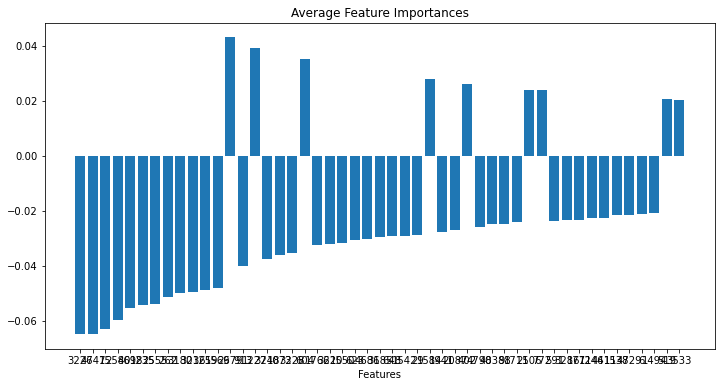

In [23]:
attr = attr[:4]
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
means = np.mean(np.mean(attr,axis=0), axis=0)
ind = np.argsort(np.absolute(means))[::-1][:int(0.05*len(means))]
visualize_importances(attacker_obj.retained_pairs[ind], means[ind])